In [1]:
# 1. setup and library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
import calendar

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# 2. load and pre-process data
try:
  # we pass 'parse_dates' to automatically convert the datetime column
  df_train = pd.read_csv('train.csv',parse_dates=['datetime'])
  df_test = pd.read_csv('test.csv',parse_dates=['datetime'])
  print("datasets 'train.csv' and 'test.csv' loaded successfully ")
  print(f"Training data shape: {df_train.shape}")
  print(f"Testingg data shape: {df_test.shape}")
except FileNotFoundError:
  print("Error : 'train.csv' or 'test.csv' not found")
  print("Please upload the file from the kaggle competition to your colab enviroment")
  exit()

print("\n --- Data Information ---")
df_train.info()



datasets 'train.csv' and 'test.csv' loaded successfully 
Training data shape: (10886, 12)
Testingg data shape: (6493, 9)

 --- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB

In [3]:
# 3. Advanced feature engineering (the core of the project)
## we will extract several new features form the 'datetime' column.

def create_time_features(df):
  df['year'] = df['datetime'].dt.year
  df['month'] = df['datetime'].dt.month
  df['day'] = df['datetime'].dt.day
  df['hour'] = df['datetime'].dt.hour
  df['day_of_week'] = df['datetime'].dt.dayofweek
  df['month_name'] = df['month'].apply(lambda x: calendar.month_name[x])
  return df

print("\n--- Enginerring new features from 'datetime' ---")
df_train = create_time_features(df_train)
df_test  = create_time_features(df_test)
print("New time-based features created")
print("Columns added: 'year','month','day','hour','day_of_week','month_name'")
print(df_train[['datetime','hour','day_of_week','month_name']].head())




--- Enginerring new features from 'datetime' ---
New time-based features created
Columns added: 'year','month','day','hour','day_of_week','month_name'
             datetime  hour  day_of_week month_name
0 2011-01-01 00:00:00     0            5    January
1 2011-01-01 01:00:00     1            5    January
2 2011-01-01 02:00:00     2            5    January
3 2011-01-01 03:00:00     3            5    January
4 2011-01-01 04:00:00     4            5    January



-- Visualizing Temporal Patterns


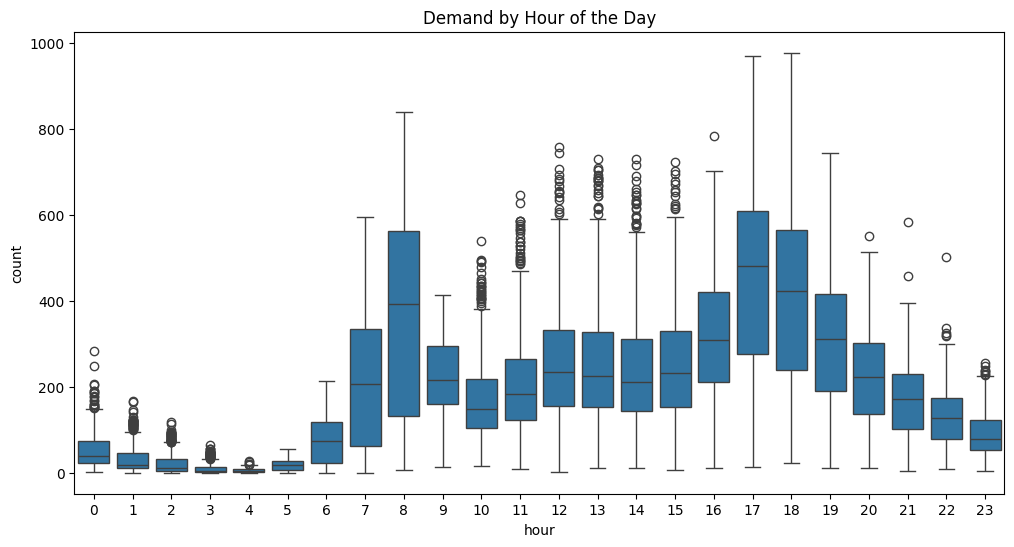

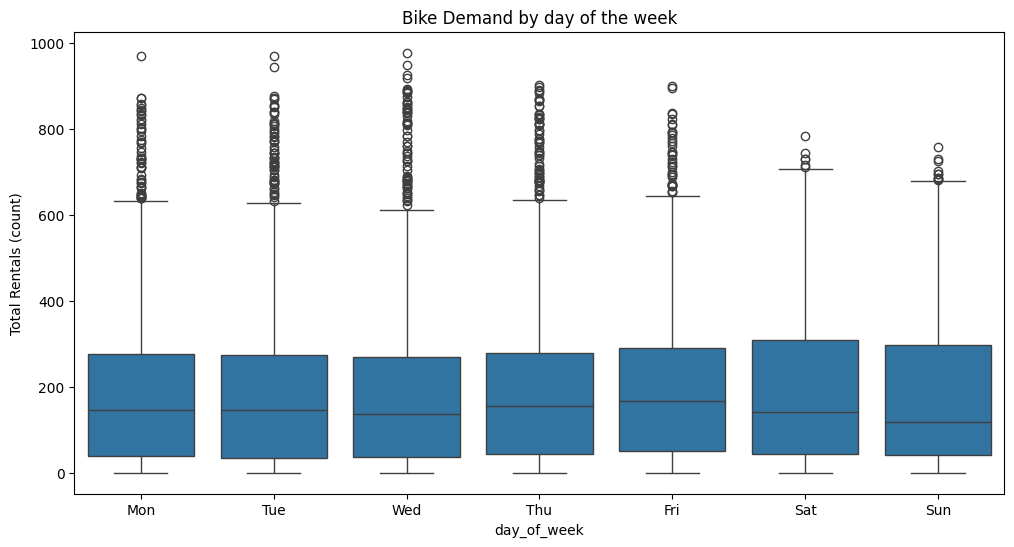

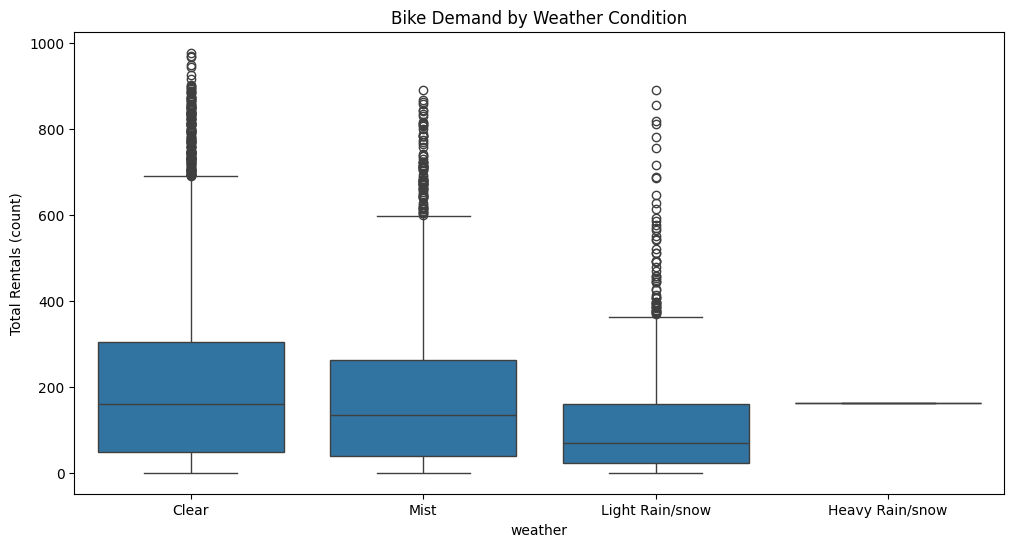

In [4]:
## 4.exploratory data analysis (EDA) on New Features
print("\n-- Visualizing Temporal Patterns")

# How does demand change by hour of the day?
plt.figure(figsize=(12,6))
sns.boxplot(x='hour',y='count',data=df_train)
plt.title('Demand by Hour of the Day')
plt.show()
# Observation: Clear peaks during morning (7-8 AM) and evening (5-6 PM) commutes.

# How does demand changeby day of the week?
plt.figure(figsize=(12,6))
sns.boxplot(x='day_of_week',y='count',data=df_train)
plt.title('Bike Demand by day of the week')
plt.xticks(ticks=range(7),labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Total Rentals (count)')
plt.show()
# observation : Higher usage during weekdays compared to weekends.

# How does weather impact demand?
plt.figure(figsize=(12,6))
sns.boxplot(x='weather',y='count',data=df_train)
plt.title('Bike Demand by Weather Condition')
plt.xticks(ticks=range(4),labels=['Clear','Mist','Light Rain/snow','Heavy Rain/snow'])
plt.ylabel('Total Rentals (count)')
plt.show()

In [5]:
# 5.Preprocessing for modeling

df_train['count'] = np.log1p(df_train['count'])



features = ['season','holiday','workingday','weather','temp','atemp',
            'humidity','windspeed','year','month','hour','day_of_week']
target = 'count'

X = df_train[features]
y = df_train[target]




In [6]:
# 6. Model Training

print("\n--- Training Gradient Boosting Regressor ---")
gbr = GradientBoostingRegressor(n_estimators=500,
                                learning_rate=0.05,
                                max_depth=4,
                                random_state=42,
                                loss='squared_error')# Default , but explicit
gbr.fit(X,y)
print("Model Training complete")



--- Training Gradient Boosting Regressor ---
Model Training complete


In [7]:
# --- 7. Evaluation ---


X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)
gbr.fit(X_train,y_train)
y_pred_val = gbr.predict(X_val)

# IMPORTANT :  The model predicts the log of the count. we must convert it back.
y_pred_val_original = np.expm1(y_pred_val)
y_val_original = np.expm1(y_val)

# calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_val_original,y_pred_val_original))
print(f"\nModel Performance on validation set: ")
print(f"Root Mean Squared Logarithmic Error (RMLSE): {rmsle:.4f}")



Model Performance on validation set: 
Root Mean Squared Logarithmic Error (RMLSE): 0.2965


In [11]:
# 8. Features Importance
# let's see which features our model found most important
print("\n--- Top 10 Most Important Features ---")
feature_importance = pd.DataFrame({
    'feature' : features,
    'importance' : gbr.feature_importances_
}).sort_values('importance',ascending=False)
print(feature_importance.head(10).to_string(index=False))


--- Top 10 Most Important Features ---
    feature  importance
       hour    0.771120
 workingday    0.048426
       temp    0.035207
       year    0.034965
day_of_week    0.031297
      month    0.028472
   humidity    0.014732
     season    0.011642
      atemp    0.011303
    weather    0.010123


In [13]:
# 9.Make prediction on Test Data
print("\n-- Making Final Prediction on the test set--")
X_test = df_test[features]
test_predictions_log = gbr.predict(X_test)

# Reverse the log transformation
final_predictions = np.expm1(test_predictions_log)

# Ensure prediction are non-negative
final_predictions[final_predictions < 0] = 0

# Create the submission file for Kaggle
submission = pd.DataFrame({
    'datetime' : df_test['datetime'],
    'count'   : final_predictions
})

submission.to_csv('submission.csv',index=False)
print("\n 'submission.csv' file created successfully!")
print("you can download this file form colab and submit it to the kaggle competition")
print(submission.head())


-- Making Final Prediction on the test set--

 'submission.csv' file created successfully!
you can download this file form colab and submit it to the kaggle competition
             datetime     count
0 2011-01-20 00:00:00  9.513164
1 2011-01-20 01:00:00  4.169261
2 2011-01-20 02:00:00  2.386503
3 2011-01-20 03:00:00  1.673625
4 2011-01-20 04:00:00  1.457141
